# Analyse machine learning de fakes news

In [152]:
import re
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

## Import des données

In [153]:
# Chargement du fichier CSV de test et nettoyage sommaire
df_test = pd.read_csv("test.csv")

In [154]:
# Chargement du fichier CSV de train et nettoyage sommaire
df_train = pd.read_csv("train.csv")

## Nettoyage des données
- suppression des données vide

In [155]:
df_test['Text'] = df_test['Text'].apply(lambda x : str(x).strip())
df_test = df_test.dropna()

df_train['Text'] = df_train['Text'].apply(lambda x : str(x).strip())
df_train = df_train.dropna()

- suppression des entrées non anglaise

In [156]:
from langdetect import detect

def detect_lang(text):
    try:
        return detect(text)
    except:
        return 'unknown'

In [157]:
df_test['lang'] = df_test['Text'].apply(detect_lang)
df_test['lang'].unique()

df_train['lang'] = df_test['Text'].apply(detect_lang)
df_train['lang'].unique()

df_train = df_train[df_train['lang'] == 'en'] # Keep only english reviews
df_test = df_test[df_test['lang'] == 'en'] # Keep only english reviews

- nettoyage de la colonne de texte avec passage de tout le texte en lowercase

In [158]:
def clean_data(text):
    # Remove all the special characters
    processed_text = re.sub(r'\W', ' ', text)
    # remove all single characters
    processed_text= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_text)
    # Remove single characters from the start
    processed_text = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_text)
    # Substituting multiple spaces with single space
    processed_text = re.sub(r'\s+', ' ', processed_text, flags=re.I)
    # Removing prefixed 'b'
    processed_text = re.sub(r'^b\s+', '', processed_text)
    # Converting to Lowercase
    processed_text = processed_text.lower()

    return processed_text

In [159]:
df_train = df_train.drop(columns={'lang'})
df_test = df_test.drop(columns={'lang'})

df_train = df_train.drop_duplicates(subset="Text")
df_test = df_test.drop_duplicates(subset="Text")

df_train['Text'] = df_train['Text'].apply(clean_data)
df_test['Text'] = df_test['Text'].apply(clean_data)


## Affichage des données nettoyées
- données d'entraînements

In [160]:
df_train

,Labels,Text,Text_Tag
0,1,says the annies list political group supports ...,abortion
1,2,when did the decline of coal start it started ...,"energy,history,job-accomplishments"
2,3,hillary clinton agrees with john mccain by vot...,foreign-policy
3,1,health care reform legislation is likely to ma...,health-care
4,2,the economic turnaround started at the end of ...,"economy,jobs"
...,...,...,...
1262,1,says new report proves the stimulus supported ...,stimulus
1263,4,says its absurd to say theres enough data to e...,"health-care,science,sports"
1264,1,the wives of the 9 11 hijackers knew exactly w...,"history,terrorism"
1265,4,says jill mccabe supports late term abortions ...,abortion


- données de tests

In [161]:
df_test

,Text,Text_Tag
0,building wall on the s mexico border will take...,immigration
1,wisconsin is on pace to double the number of l...,jobs
2,says john mccain has done nothing to help the ...,"military,veterans,voting-record"
3,suzanne bonamici supports plan that will cut c...,"medicare,message-machine-2012,campaign-adverti..."
4,when asked by reporter whether hes at the cent...,"campaign-finance,legal-issues,campaign-adverti..."
...,...,...
1262,says his budget provides the highest state fun...,education
1263,ive been here almost every day,"civil-rights,crime,criminal-justice"
1264,in the early 1980s sen edward kennedy secretly...,"bipartisanship,congress,foreign-policy,history"
1265,says an epa permit languished under strickland...,"environment,government-efficiency"


## Analyse des données nettoyées 

In [162]:
# Nombre de mots uniques

def findWordsCount(column):
    # Créer un ensemble pour stocker les mots
    mots = set()

    # Parcourir les reviews et ajouter chaque mot à l'ensemble
    for review in column:
        for word in review.split():
            mots.add(word)
    return len(mots)

df_test_unique_words_count = findWordsCount(df_test['Text'])
df_train_unique_words_count = findWordsCount(df_train['Text'])
print(f"Nombre de mots uniques dans les données de test : {df_test_unique_words_count}")
print(f"Nombre de mots uniques dans les données de train : {df_train_unique_words_count}")

Nombre de mots uniques dans les données de test : 4362
Nombre de mots uniques dans les données de train : 4304


### Répartition des labels
On observe que sur les données de test, les données des labels sont globalement équilibréés. Seule la catégorie 4 est sous-représentée.

In [163]:
counts_labels = df_train['Labels'].value_counts()
counts_labels

Labels
1    261
2    258
3    251
5    202
0    187
4    103
Name: count, dtype: int64

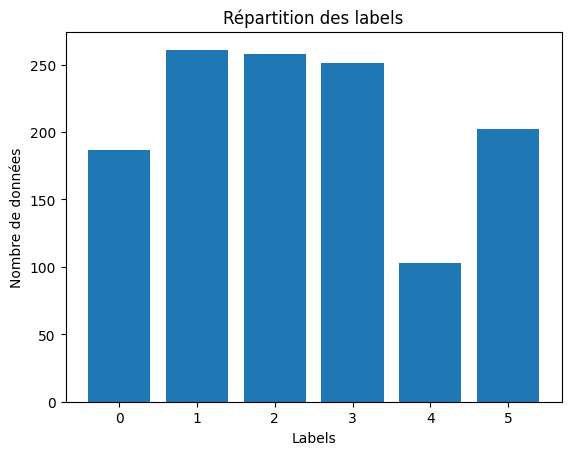

In [164]:
plt.bar(counts_labels.index, counts_labels.values)
plt.xlabel('Labels')
plt.ylabel('Nombre de données')
plt.title('Répartition des labels')
plt.show()

In [165]:
counts_tags = df_train['Text_Tag'].value_counts()
counts_tags

Text_Tag
taxes                                                                       41
immigration                                                                 38
health-care                                                                 36
education                                                                   36
elections                                                                   32
                                                                            ..
health-care,new-hampshire-2012,abc-news-week                                 1
immigration,military,terrorism                                               1
children,education,federal-budget,government-regulation                      1
city-government,civil-rights,criminal-justice,public-safety,state-budget     1
fake-news                                                                    1
Name: count, Length: 718, dtype: int64

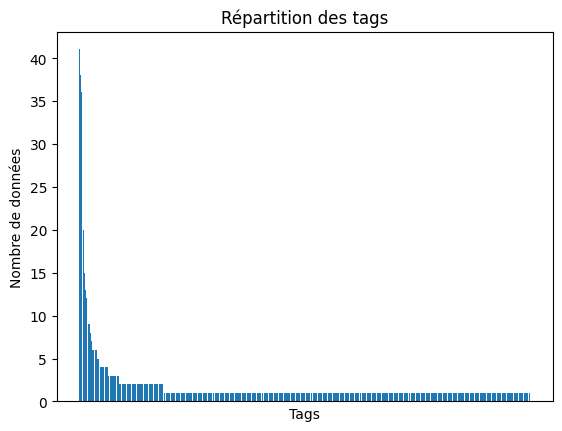

In [166]:
plt.bar(counts_tags.index, counts_tags.values)
plt.xlabel('Tags')
plt.ylabel('Nombre de données')
plt.title('Répartition des tags')
plt.xticks([])
plt.show()

On observe que certains tags sont beaucoup plus présents que d'autres mais nous pouvons également remarquer que certains tags sont composés. Il est donc difficile de tirer des informations pertinentes de ces données.

/tmp/ipykernel_13389/1006231693.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


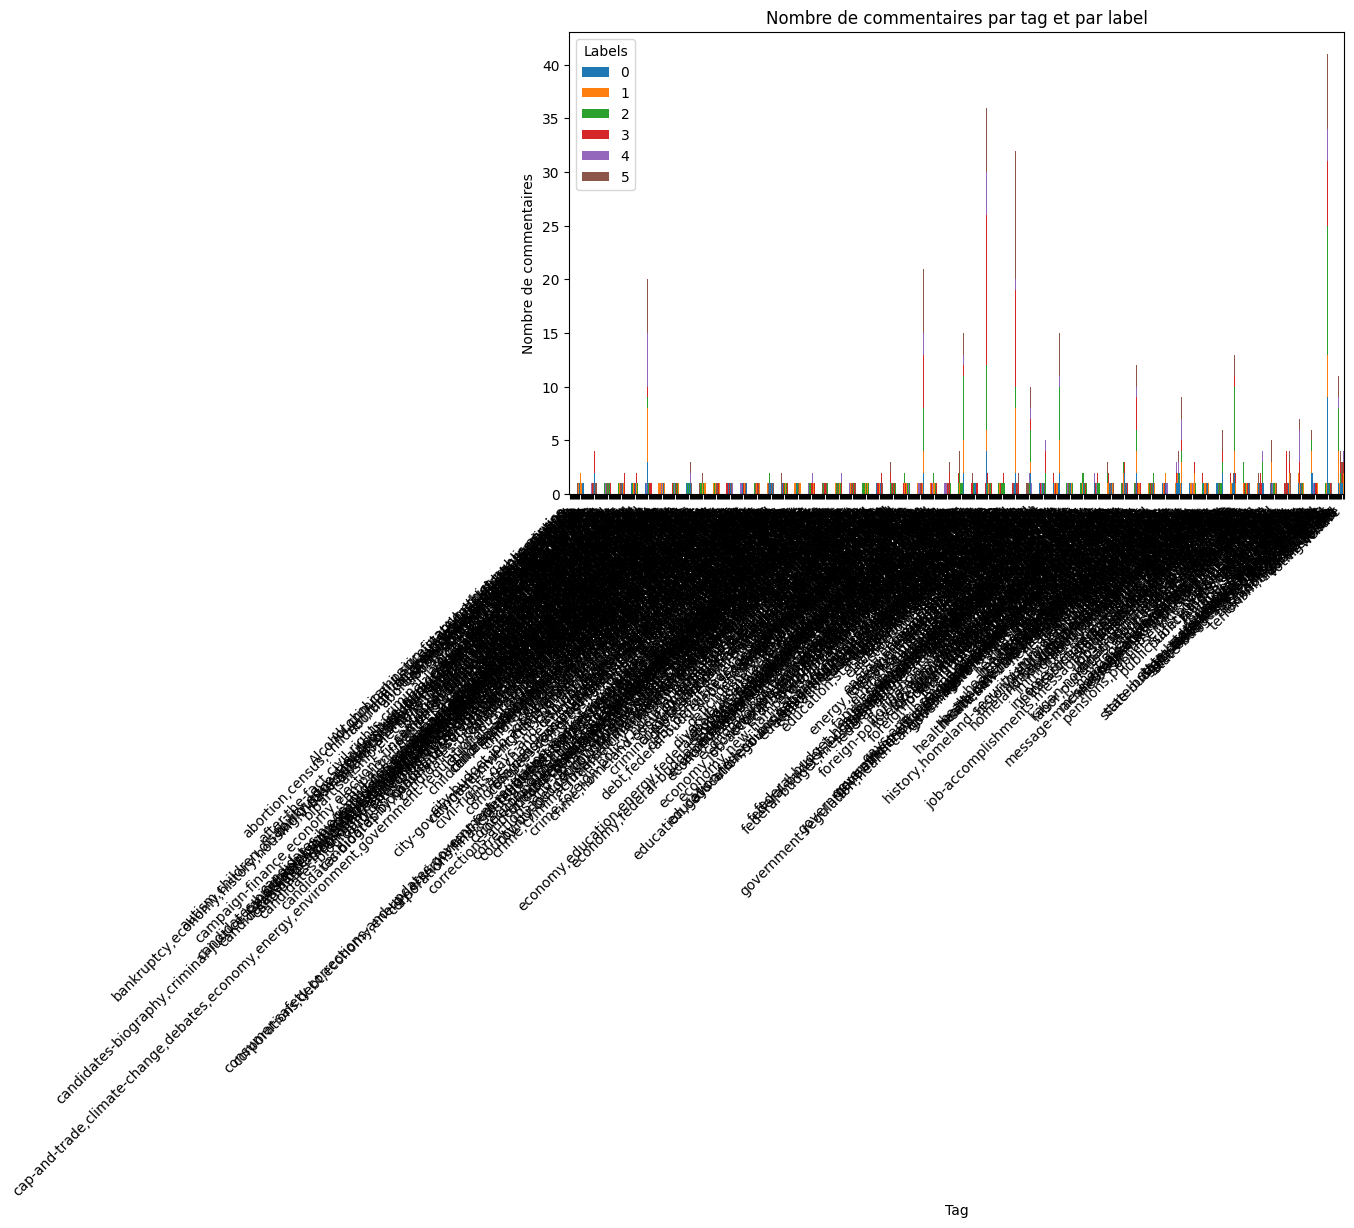

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Comptage du nombre de commentaires pour chaque tag et label
tag_label_counts = df_train.groupby(['Text_Tag', 'Labels']).size().unstack(fill_value=0)

# Histogramme
tag_label_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Nombre de commentaires par tag et par label')
plt.xlabel('Tag')
plt.ylabel('Nombre de commentaires')
plt.legend(title='Labels')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

On remarque une grande disparité dans le nombre de commentaires par tag, si nous souhaitons avoir des informations plus pertinente, il serait judicieux de ne s'interesser qu'au tag apparaissant au moins 5 fois dans le liste des commentaires.

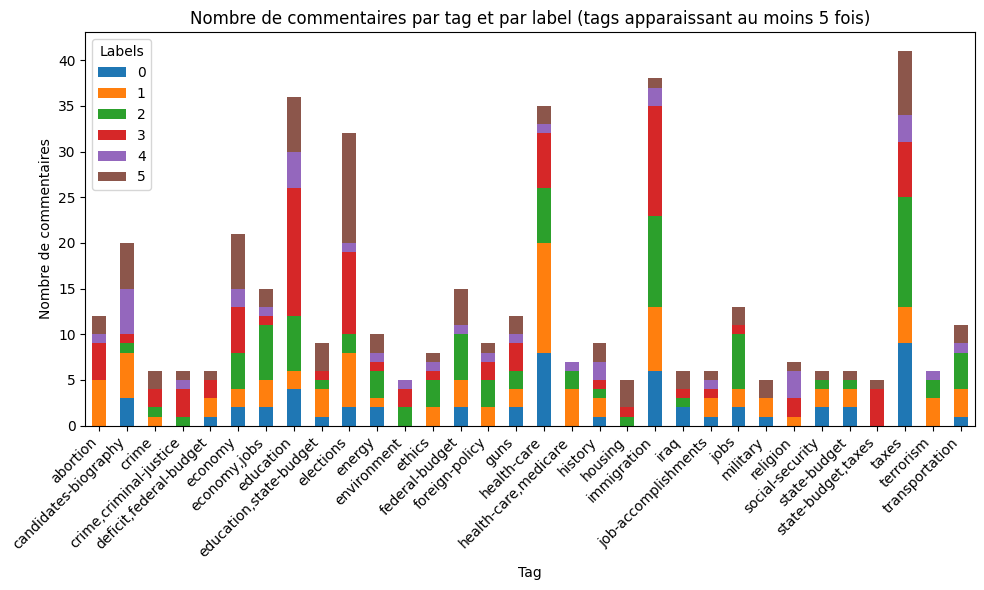

In [20]:
import matplotlib.pyplot as plt

# Compter le nombre d'occurrences de chaque tag
tag_counts = df_train['Text_Tag'].value_counts()

# Filtrer les tags qui apparaissent au moins 5 fois
tags_to_plot = tag_counts[tag_counts >= 5].index

# Filtrer le DataFrame original pour ne conserver que les lignes correspondant à ces tags
filtered_df = df_train[df_train['Text_Tag'].isin(tags_to_plot)]

# Comptage du nombre de commentaires pour chaque tag et label
tag_label_counts = filtered_df.groupby(['Text_Tag', 'Labels']).size().unstack(fill_value=0)

# Histogramme
tag_label_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Nombre de commentaires par tag et par label (tags apparaissant au moins 5 fois)')
plt.xlabel('Tag')
plt.ylabel('Nombre de commentaires')
plt.legend(title='Labels')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


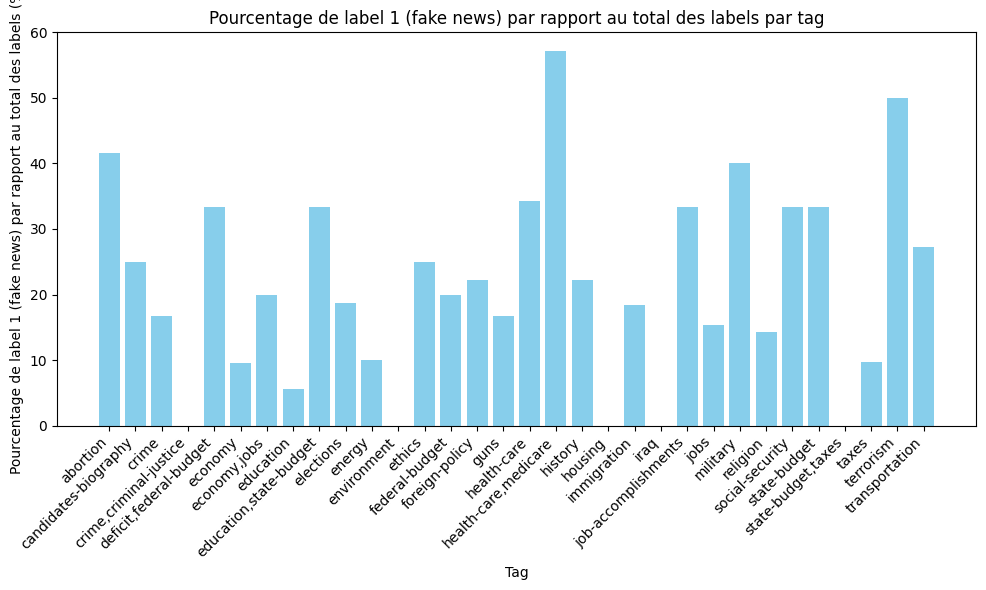

In [24]:
import matplotlib.pyplot as plt

# Calculer le nombre total de commentaires pour chaque tag
tag_total_comments = tag_label_counts.sum(axis=1)

# Calculer le pourcentage de commentaires avec le label 1 (fake news) pour chaque tag
fake_news_percentage = (tag_label_counts[1] / tag_total_comments) * 100

# Calculer le pourcentage de commentaires avec le label 1 (fake news) par rapport au total des labels pour chaque tag
total_labels_percentage = (tag_label_counts[1] / tag_label_counts.sum(axis=1)) * 100

# Créer un graphique à barres pour afficher les pourcentages
plt.figure(figsize=(10, 6))
plt.bar(fake_news_percentage.index, total_labels_percentage, color='skyblue')

# Ajouter des titres et des étiquettes
plt.title('Pourcentage de label 1 (fake news) par rapport au total des labels par tag')
plt.xlabel('Tag')
plt.ylabel('Pourcentage de label 1 (fake news) par rapport au total des labels (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Afficher le graphique
plt.show()


On remarque que pour certains tags tel que "health-care,medicare" et terrorism", le pourcentage de fake news est très élevé (>50%). D'autres tags ont un pourcentage de fake news élevé également. 
Les tags peuvent donc nous fournir des informations supplémentaires pertinentes quant à la probabilité de la véracité de l'information. Il sera donc intéressant d'ajouter cette colonne à notre jeu de données.

### Etape de tokenisation

In [167]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

df_train['Tokens'] = df_train['Text'].apply(tokenize_text)
df_train

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


,Labels,Text,Text_Tag,Tokens
0,1,says the annies list political group supports ...,abortion,"[says, the, annies, list, political, group, su..."
1,2,when did the decline of coal start it started ...,"energy,history,job-accomplishments","[when, did, the, decline, of, coal, start, it,..."
2,3,hillary clinton agrees with john mccain by vot...,foreign-policy,"[hillary, clinton, agrees, with, john, mccain,..."
3,1,health care reform legislation is likely to ma...,health-care,"[health, care, reform, legislation, is, likely..."
4,2,the economic turnaround started at the end of ...,"economy,jobs","[the, economic, turnaround, started, at, the, ..."
...,...,...,...,...
1262,1,says new report proves the stimulus supported ...,stimulus,"[says, new, report, proves, the, stimulus, sup..."
1263,4,says its absurd to say theres enough data to e...,"health-care,science,sports","[says, its, absurd, to, say, theres, enough, d..."
1264,1,the wives of the 9 11 hijackers knew exactly w...,"history,terrorism","[the, wives, of, the, 9, 11, hijackers, knew, ..."
1265,4,says jill mccabe supports late term abortions ...,abortion,"[says, jill, mccabe, supports, late, term, abo..."


### Etape de vectorisation

In [168]:
from tensorflow.keras.layers import TextVectorization

max_length = 100
vocabs = 1000

In [169]:
vectorize_layer = TextVectorization(
    # standardize=custom_standardization, # To be used instead of pre processing the text before
    max_tokens=vocabs,
    output_mode='int',
    output_sequence_length=max_length)

In [170]:
from sklearn.model_selection import train_test_split
y = df_train["Labels"]
x = df_train['Text']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=32)

In [171]:
y_test

607     0
753     5
866     0
1181    5
255     2
       ..
1180    1
291     5
301     3
1110    2
931     5
Name: Labels, Length: 253, dtype: int64

In [172]:
vectorize_layer.adapt(x_train.values)

In [173]:
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, Flatten, LSTM, Dropout, GRU, GlobalAveragePooling1D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [174]:
model = Sequential([
    vectorize_layer,
    Embedding(input_dim = vocabs, output_dim = 100, input_length=max_length),
    # LSTM(128, recurrent_activation="sigmoid"),
    GlobalAveragePooling1D(),
    Dense(128, activation="relu"), # https://en.wikipedia.org/wiki/Rectifier_(neural_networks)
    # Dropout(0.2), # Randomly set inputs to 0 with the probability in input, here 0.2 to prevent overfitting
    Dense(6, activation = "Softmax"), # Output function
])

In [175]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_4 (Text  (None, 100)               0         
 Vectorization)                                                  
                                                                 
 embedding_8 (Embedding)     (None, 100, 100)          100000    
                                                                 
 global_average_pooling1d_4  (None, 100)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_8 (Dense)             (None, 128)               12928     
                                                                 
 dense_9 (Dense)             (None, 6)                 774       
                                                                 
Total params: 113702 (444.15 KB)
Trainable params: 113

In [199]:
def toVector(column):
  vector = []
  for val in column:
    res = [0, 0, 0, 0, 0, 0]
    res[val] = 1
    vector.append(res)
  return np.array(vector)

Définition des poids en fonction des text_tag qui ont plus de chance de contenir des fausses informations

In [204]:
# Définir les poids
weights = np.ones(len(x_train))
weights[np.isin(y_train, ["terrorism"])] = 10
weights[np.isin(y_train, ["health-care"])] = 10
weights[np.isin(y_train, ["medicare"])] = 10
weights[np.isin(y_train, ["abortion"])] = 10

In [205]:

model.compile(optimizer=Adam(learning_rate=0.001), # Optimizer modifies the weights with specified learning rate
              loss=CategoricalCrossentropy(),
              metrics=[tf.metrics.AUC()],
              )
  
history = model.fit(x_train, toVector(y_train),
          initial_epoch=0,
          epochs=32,
          validation_data=(x_test, toVector(y_test)),
          batch_size=32,
          sample_weight=weights,
        #   callbacks = callback
          )

Epoch 1/32
32/32 [==============================] - 3s 27ms/step - loss: 4.0528e-04 - auc_26: 1.0000 - val_loss: 11.8847 - val_auc_26: 0.5403
Epoch 2/32
32/32 [==============================] - 0s 7ms/step - loss: 0.0028 - auc_26: 1.0000 - val_loss: 11.7419 - val_auc_26: 0.5342
Epoch 3/32
32/32 [==============================] - 0s 7ms/step - loss: 0.0011 - auc_26: 1.0000 - val_loss: 11.7503 - val_auc_26: 0.5302
Epoch 4/32
32/32 [==============================] - 0s 7ms/step - loss: 2.3162e-04 - auc_26: 1.0000 - val_loss: 11.8211 - val_auc_26: 0.5289
Epoch 5/32
32/32 [==============================] - 0s 7ms/step - loss: 5.5239e-05 - auc_26: 1.0000 - val_loss: 11.8596 - val_auc_26: 0.5318
Epoch 6/32
32/32 [==============================] - 0s 7ms/step - loss: 4.9026e-05 - auc_26: 1.0000 - val_loss: 11.8622 - val_auc_26: 0.5320
Epoch 7/32
32/32 [==============================] - 0s 7ms/step - loss: 4.7912e-05 - auc_26: 1.0000 - val_loss: 11.8792 - val_auc_26: 0.5316
Epoch 8/32
32/32 [==

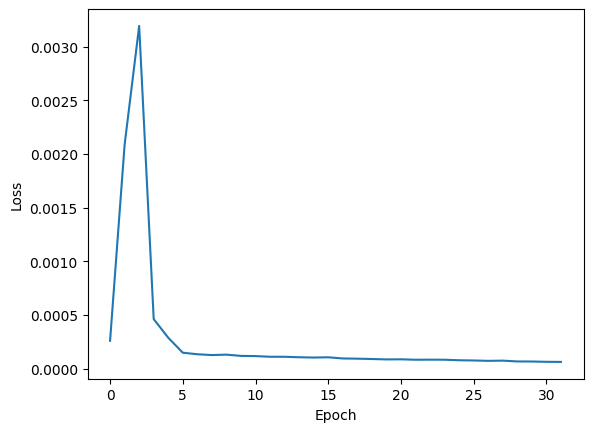

In [202]:
loss = history.history["loss"]
plt.plot(loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

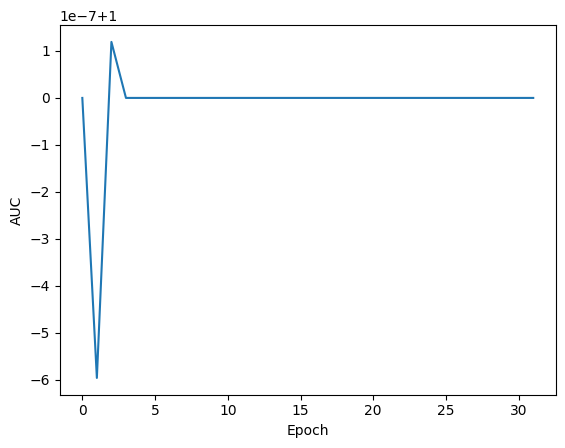

In [207]:
auc = history.history["auc_26"]
plt.plot(auc)
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.show()

Sur 32 itération d'entrainement du modèle, on constate sur le graphique que la valeur de la loss tend à diminuer


plus d'epochs serait contre productif, le modèle devient overfitted au bout de x epochs (réduire le nombre de neuronnes, couches de droppout, ...)

Pour 100 epochs on a pour le graphique de la loss :

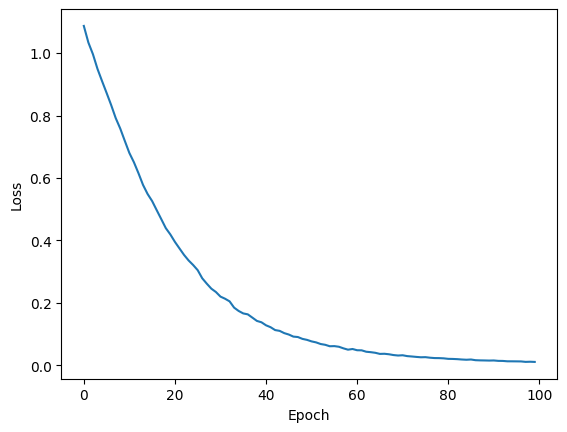

Et pour le graphique de l'AUC :

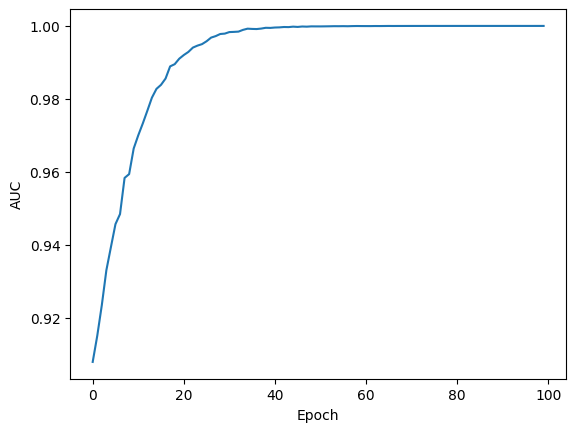

In [ ]:
model.evaluate(x_test, toVector(y_test)) # Returns loss and accuracy

8/8 [==============================] - 0s 6ms/step - loss: 10.3880 - auc_24: 0.5288


[10.38796329498291, 0.5288491249084473]

Notre modèle est overfitted, il n'est plus capable de gérer de nouvelles données car il a trop été entrainé sur les données d'entrainement.



## Enregistrement du modèle

In [208]:
tf.keras.models.save_model(model, "CADET_HERB_SCHWARTZ_model")

INFO:tensorflow:Assets written to: CADET_HERB_SCHWARTZ_model\assets


INFO:tensorflow:Assets written to: CADET_HERB_SCHWARTZ_model\assets
